In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import seaborn as sns
import matplotlib.pyplot as plt
import ROOT
try:
    #plt.style.use('belle2')
    #plt.style.use('belle2_serif')
    plt.style.use('belle2_modern')
except OSError:
    print("Please install belle2 matplotlib style")   

px = 1/plt.rcParams['figure.dpi']

Welcome to JupyROOT 6.26/04


In [2]:
import os
import pandas as pd
import numpy as np
from pandas import HDFStore
from os import path
from yaml import safe_load

from hist.get_data import get_data
from hist.bkg_stack import generic_ntuple, get_data_in_module
from read_yaml_to_dict import read_yaml_to_dict
from src.sample_name import sample_name
from src.combine_cuts import combine_cuts
print(os.getcwd())

For optimal usage set `plt.style.use('belle2')`
['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'belle2', 'belle2_modern', 'belle2_serif', 'belle2_wg1', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']
/home/jykim/workspace/DRAW/read_yaml_to_dict.py
/home/jykim/workspace/DRAW
{'Vegetables': ['Pepper', 'Tomato', 'Garlic']}
/home/jykim/workspace/DRAW


In [3]:
def get_data(file='file', figname='name', tree='tree', base_filter=None,variables=None):
    
    tree=tree
    f = file
    base_filter  = base_filter    
    
    ROOT_df_start = ROOT.RDataFrame(tree, f)  
    
    col_dict  = ROOT_df_start.AsNumpy(variables)
    
    if base_filter !=None:
        ROOT_df_filtered  = ROOT_df_start.Filter(base_filter)                            
        col_dict  = ROOT_df_filtered.AsNumpy(variables)
    
    pd_df  = pd.DataFrame(col_dict)
    
    return pd_df

In [19]:
file='/media/jykim/ssd_T5/storage/01_recon/antiKstar/massveto_signalMC_recon_mdst_antiKstar.root'
bkg_file = '/media/jykim/ssd_T5/storage/hdf_files/massveto_antiKstar.h5'

In [20]:
base_filter = 'Dstarp_isSignal==1'

tree = 'antiKstar'

variables=['ROE_Pi0_InvM','ROE_Pi0_InvM_50MeV','ROE_Pi0_InvM_75MeV','ROE_Pi0_InvM_100MeV','ROE_Pi0_InvM_125MeV','ROE_Pi0_InvM_150MeV']
variables+= ['ROE_Eta_InvM','ROE_Eta_InvM_50MeV','ROE_Eta_InvM_75MeV','ROE_Eta_InvM_100MeV','ROE_Eta_InvM_125MeV','ROE_Eta_InvM_150MeV','ROE_Eta_InvM_175MeV','ROE_Eta_InvM_200MeV']

#pd_df = get_data(file=file, tree=tree,variables=variables ,base_filter=base_filter)

In [21]:
pd_df_signal = get_data(file=file, tree=tree,variables=variables ,base_filter=base_filter)

pd_df_bkg = pd.read_hdf(bkg_file, key='jykim')
cols = ['Pi0_soft_genMotherPDG_50MeV','Pi0_soft_genMotherPDG_75MeV','gamma_genMotherPDG','Pi0_soft_genMotherID_50MeV','gamma_genMotherID','Eta_soft_genMotherPDG_50MeV','Eta_soft_genMotherPDG_75MeV','Eta_soft_genMotherPDG_125MeV']
pd_df_bkg[cols]=pd_df_bkg[cols].fillna(0.0).astype(int)
# Pi0_bkg_cuts = 'gamma_genMotherPDG==111'
Pi0_bkg_cuts = 'gamma_E>0.1'
Pi0_selected_pd_df_bkg = pd_df_bkg.query(Pi0_bkg_cuts)


In [22]:
def eff(Total_row_num=None, Reduced_row_num=None):
    eff = Reduced_row_num/Total_row_num
    return eff

def Bkg_rej(Total_row_num=None, Reduced_row_num=None):
    rejection = (Total_row_num - Reduced_row_num)/Total_row_num

    return rejection

In [23]:
nominal_pi0_mass = 0.1325
nominal_eta_mass = 0.54786
#nominal_pi0_mass = 0.13498

In [24]:
step = 0.0005
sig_Total_row_num = pd_df_signal.shape[0]
Pi0_bkg_Total_row_num = Pi0_selected_pd_df_bkg.shape[0]
width_mass = 0.0

data_dict = dict.fromkeys(['sig_eff', 'bkg_rej'])
data_dict['sig_eff']=list()
data_dict['bkg_rej']=list()
print(data_dict)
# sig_eff_list = list()
# bkg_rej_list = list()
sig_Reduced_row_num = pd_df_signal.shape[0]
data_dict['sig_eff'].append(eff(sig_Total_row_num, sig_Reduced_row_num ))
Pi0_bkg_Reduced_row_num = Pi0_selected_pd_df_bkg.shape[0]
data_dict['bkg_rej'].append(Bkg_rej(Pi0_bkg_Total_row_num, Pi0_bkg_Reduced_row_num)) 
for i in range(1,100):     
    if width_mass < 0.025:
        width_mass     = 0 + i * step
        min_mass_bound = nominal_pi0_mass - width_mass  
        max_mass_bound = nominal_pi0_mass + width_mass
        #print(width_mass)
        sig_Reduced_row_num = pd_df_signal[(pd_df_signal['ROE_Pi0_InvM_50MeV']<min_mass_bound) | (pd_df_signal['ROE_Pi0_InvM_50MeV']>max_mass_bound)].shape[0]
        data_dict['sig_eff'].append(eff(sig_Total_row_num, sig_Reduced_row_num ))
        #sig_eff_list.append(eff(sig_Total_row_num, sig_Reduced_row_num ))
        
        Pi0_bkg_Reduced_row_num = Pi0_selected_pd_df_bkg[(Pi0_selected_pd_df_bkg['ROE_Pi0_InvM_50MeV']<min_mass_bound) | (Pi0_selected_pd_df_bkg['ROE_Pi0_InvM_50MeV']>max_mass_bound)].shape[0]
        data_dict['bkg_rej'].append(Bkg_rej(Pi0_bkg_Total_row_num, Pi0_bkg_Reduced_row_num))
        
        #bkg_rej_list.append(Bkg_rej(Pi0_bkg_Total_row_num, Pi0_bkg_Reduced_row_num))        
        
        


{'sig_eff': [], 'bkg_rej': []}


In [25]:
df_50MeV = pd.DataFrame(data_dict)

In [26]:
step = 0.0005
sig_Total_row_num = pd_df_signal.shape[0]
Pi0_bkg_Total_row_num = Pi0_selected_pd_df_bkg.shape[0]
width_mass = 0.0

data_dict = dict.fromkeys(['sig_eff', 'bkg_rej'])
data_dict['sig_eff']=list()
data_dict['bkg_rej']=list()
sig_Reduced_row_num = pd_df_signal.shape[0]
data_dict['sig_eff'].append(eff(sig_Total_row_num, sig_Reduced_row_num ))
Pi0_bkg_Reduced_row_num = Pi0_selected_pd_df_bkg.shape[0]
data_dict['bkg_rej'].append(Bkg_rej(Pi0_bkg_Total_row_num, Pi0_bkg_Reduced_row_num)) 
for i in range(1,100):
    if width_mass < 0.025:
        width_mass     = 0 + i * step
        min_mass_bound = nominal_pi0_mass - width_mass  
        max_mass_bound = nominal_pi0_mass + width_mass
        #print(width_mass)
        sig_Reduced_row_num = pd_df_signal[(pd_df_signal['ROE_Pi0_InvM_75MeV']<min_mass_bound) | (pd_df_signal['ROE_Pi0_InvM_75MeV']>max_mass_bound)].shape[0]
        data_dict['sig_eff'].append(eff(sig_Total_row_num, sig_Reduced_row_num ))
        #sig_eff_list.append(eff(sig_Total_row_num, sig_Reduced_row_num ))
        
        Pi0_bkg_Reduced_row_num = Pi0_selected_pd_df_bkg[(Pi0_selected_pd_df_bkg['ROE_Pi0_InvM_75MeV']<min_mass_bound) | (Pi0_selected_pd_df_bkg['ROE_Pi0_InvM_75MeV']>max_mass_bound)].shape[0]
        data_dict['bkg_rej'].append(Bkg_rej(Pi0_bkg_Total_row_num, Pi0_bkg_Reduced_row_num))
        
        #bkg_rej_list.append(Bkg_rej(Pi0_bkg_Total_row_num, Pi0_bkg_Reduced_row_num))   

In [27]:
df_75MeV = pd.DataFrame(data_dict)
#Y = pd.DataFrame(bkg_rej_list)



In [28]:
step = 0.0005
sig_Total_row_num = pd_df_signal.shape[0]
Pi0_bkg_Total_row_num = Pi0_selected_pd_df_bkg.shape[0]
width_mass = 0.0

data_dict = dict.fromkeys(['sig_eff', 'bkg_rej'])
data_dict['sig_eff']=list()
data_dict['bkg_rej']=list()
sig_Reduced_row_num = pd_df_signal.shape[0]
data_dict['sig_eff'].append(eff(sig_Total_row_num, sig_Reduced_row_num ))
Pi0_bkg_Reduced_row_num = Pi0_selected_pd_df_bkg.shape[0]
data_dict['bkg_rej'].append(Bkg_rej(Pi0_bkg_Total_row_num, Pi0_bkg_Reduced_row_num)) 
for i in range(1,100):
    if width_mass < 0.025:
        width_mass     = 0 + i * step
        min_mass_bound = nominal_pi0_mass - width_mass  
        max_mass_bound = nominal_pi0_mass + width_mass
        #print(width_mass)
        sig_Reduced_row_num = pd_df_signal[(pd_df_signal['ROE_Pi0_InvM_100MeV']<min_mass_bound) | (pd_df_signal['ROE_Pi0_InvM_100MeV']>max_mass_bound)].shape[0]
        data_dict['sig_eff'].append(eff(sig_Total_row_num, sig_Reduced_row_num ))
        #sig_eff_list.append(eff(sig_Total_row_num, sig_Reduced_row_num ))
        
        Pi0_bkg_Reduced_row_num = Pi0_selected_pd_df_bkg[(Pi0_selected_pd_df_bkg['ROE_Pi0_InvM_100MeV']<min_mass_bound) | (Pi0_selected_pd_df_bkg['ROE_Pi0_InvM_100MeV']>max_mass_bound)].shape[0]
        data_dict['bkg_rej'].append(Bkg_rej(Pi0_bkg_Total_row_num, Pi0_bkg_Reduced_row_num))
        
        #bkg_rej_list.append(Bkg_rej(Pi0_bkg_Total_row_num, Pi0_bkg_Reduced_row_num))   

In [29]:
df_100MeV = pd.DataFrame(data_dict)
#Y = pd.DataFrame(bkg_rej_list)



In [30]:
step = 0.0010
sig_Total_row_num = pd_df_signal.shape[0]
Pi0_bkg_Total_row_num = Pi0_selected_pd_df_bkg.shape[0]
width_mass = 0.0

data_dict = dict.fromkeys(['sig_eff', 'bkg_rej'])
data_dict['sig_eff']=list()
data_dict['bkg_rej']=list()
sig_Reduced_row_num = pd_df_signal.shape[0]
data_dict['sig_eff'].append(eff(sig_Total_row_num, sig_Reduced_row_num ))
Pi0_bkg_Reduced_row_num = Pi0_selected_pd_df_bkg.shape[0]
data_dict['bkg_rej'].append(Bkg_rej(Pi0_bkg_Total_row_num, Pi0_bkg_Reduced_row_num)) 
for i in range(1,100):
    if width_mass < 0.025:
        width_mass     = 0 + i * step
        min_mass_bound = nominal_pi0_mass - width_mass  
        max_mass_bound = nominal_pi0_mass + width_mass
        #print(width_mass)
        sig_Reduced_row_num = pd_df_signal[(pd_df_signal['ROE_Pi0_InvM_125MeV']<min_mass_bound) | (pd_df_signal['ROE_Pi0_InvM_125MeV']>max_mass_bound)].shape[0]
        data_dict['sig_eff'].append(eff(sig_Total_row_num, sig_Reduced_row_num ))
        #sig_eff_list.append(eff(sig_Total_row_num, sig_Reduced_row_num ))
        
        Pi0_bkg_Reduced_row_num = Pi0_selected_pd_df_bkg[(Pi0_selected_pd_df_bkg['ROE_Pi0_InvM_125MeV']<min_mass_bound) | (Pi0_selected_pd_df_bkg['ROE_Pi0_InvM_125MeV']>max_mass_bound)].shape[0]
        data_dict['bkg_rej'].append(Bkg_rej(Pi0_bkg_Total_row_num, Pi0_bkg_Reduced_row_num))
        
        #bkg_rej_list.append(Bkg_rej(Pi0_bkg_Total_row_num, Pi0_bkg_Reduced_row_num))   

In [31]:
df_125MeV = pd.DataFrame(data_dict)

(0.0, 1.0)

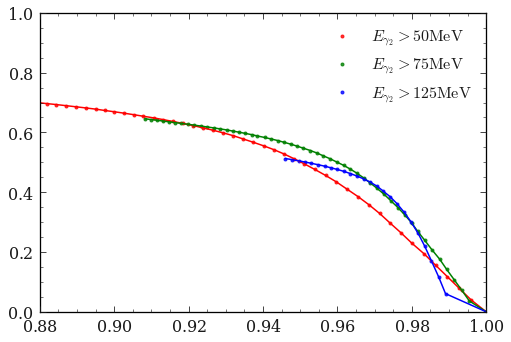

In [32]:
plt.scatter(df_50MeV.sig_eff, df_50MeV.bkg_rej , alpha=0.8, marker='.',c='red',label=r'$E_{\gamma_2}>50\mathrm{MeV}$')
plt.scatter(df_75MeV.sig_eff, df_75MeV.bkg_rej, alpha=0.8, marker='.',c='green',label=r'$E_{\gamma_2}>75\mathrm{MeV}$')
plt.scatter(df_125MeV.sig_eff, df_125MeV.bkg_rej, alpha=0.8, marker='.',c='blue',label=r'$E_{\gamma_2}>125\mathrm{MeV}$')
# plt.scatter(df.sig_eff, df.bkg_rej, alpha=0.8, marker='*',c='black',label=r'FBDT')

plt.plot(df_50MeV.sig_eff, df_50MeV.bkg_rej,c='red')
plt.plot(df_75MeV.sig_eff, df_75MeV.bkg_rej,c='green')
plt.plot(df_125MeV.sig_eff, df_125MeV.bkg_rej,c='blue')
# plt.plot(df.sig_eff, df.bkg_rej,c='black')

plt.legend()
ax = plt.gca()
ax.set_xlim(0.88,1) 
# ax.set_xlim(0,1)   

ax.set_ylim(0,1)

In [165]:
df_50MeV

,sig_eff,bkg_rej
0,1.000000,0.000000
1,0.995960,0.039546
2,0.992744,0.078591
3,0.989557,0.117451
4,0.986387,0.155803
5,0.983357,0.193365
6,0.979983,0.229768
7,0.977070,0.264416
8,0.974099,0.297447
9,0.971349,0.328891


(0.0, 1.0)

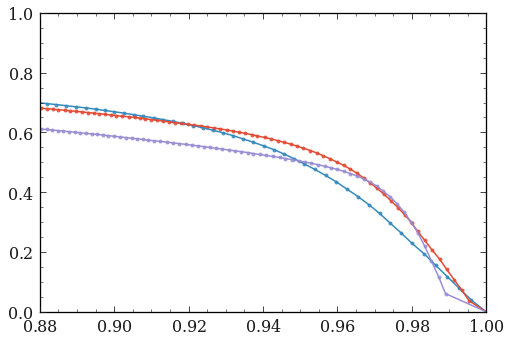

In [166]:
plt.scatter(df_50MeV.sig_eff, df_50MeV.bkg_rej, alpha=0.8, marker='.')
plt.scatter(df_75MeV.sig_eff, df_75MeV.bkg_rej, alpha=0.8, marker='.')
plt.scatter(df_125MeV.sig_eff, df_125MeV.bkg_rej, alpha=0.8, marker='.')


plt.plot(df_50MeV.sig_eff, df_50MeV.bkg_rej)
plt.plot(df_75MeV.sig_eff, df_75MeV.bkg_rej)
plt.plot(df_125MeV.sig_eff, df_125MeV.bkg_rej)

ax = plt.gca()
ax.set_xlim(0.88,1)   
ax.set_ylim(0,1)

In [155]:
# plt.scatter(df_50MeV.sig_eff, df_50MeV.bkg_rej)
# plt.scatter(df_75MeV.sig_eff, df_75MeV.bkg_rej)
# plt.scatter(df_125MeV.sig_eff, df_125MeV.bkg_rej)

# ax = plt.gca()
# ax.set_xlim(0.88,1)   
# ax.set_ylim(0,1)

In [56]:
file = '/media/jykim/ssd_T5/storage/01_recon/merge_generic_bkg/ccbar/train_v1_1_no_signal_ccbar_recon_output_0*.root'
tree = 'antiKstar'
variables=['Pi0_Prob','D0_M','Eta_Prob']

base_filter = 'gamma_genMotherPDG==111'
base_filter = 'gamma_E>0.1'

ccbar_df = get_data(file=file, tree=tree,variables=variables ,base_filter=base_filter)

file = file.replace('ccbar','mixed')
mixed_df = get_data(file=file, tree=tree,variables=variables ,base_filter=base_filter)

file = file.replace('mixed','ddbar')
ddbar_df = get_data(file=file, tree=tree,variables=variables ,base_filter=base_filter)

file = file.replace('ddbar','ssbar')
ssbar_df = get_data(file=file, tree=tree,variables=variables ,base_filter=base_filter)

file = file.replace('ssbar','taupair')
taupair_df = get_data(file=file, tree=tree,variables=variables ,base_filter=base_filter)

file = file.replace('taupair','uubar')
uubar_df = get_data(file=file, tree=tree,variables=variables ,base_filter=base_filter)

file = file.replace('uubar','charged')
charged_df = get_data(file=file, tree=tree,variables=variables, base_filter=base_filter)


In [57]:
merged_pd_df = pd.concat([ccbar_df, mixed_df, ddbar_df, ssbar_df, taupair_df, uubar_df, charged_df], ignore_index=True)
#base_filter = '(D0_M>1.665 && D0_M<2.065) && (gamma_E>0.55)  && ( abs(Rho_M- 0.77526) < 0.150 ) &&  Dstarp_CMS_p>2.72 && abs(Dstarp_Q-0.00593)<0.0006'




In [58]:
merged_pd_df.describe()

,Pi0_Prob,D0_M,Eta_Prob
count,4.638653e+06,4.638661e+06,4.638480e+06
mean,8.540547e-01,1.823277e+00,6.274067e-01
std,2.607176e-01,1.085576e-01,3.056782e-01
min,7.430211e-05,8.333485e-01,8.004790e-05
25%,8.812863e-01,1.734168e+00,3.729646e-01
50%,9.763084e-01,1.804145e+00,6.977651e-01
75%,9.923617e-01,1.899617e+00,9.133362e-01
max,9.993101e-01,3.812553e+00,9.998906e-01


In [59]:
file='/media/jykim/ssd_T5/storage/01_recon/antiKstar/expert_E_0_3_signalMC_recon_mdst_antiKstar.root'

In [60]:
base_filter = 'Dstarp_isSignal==1'

tree = 'antiKstar'

#variables=['ROE_Pi0_InvM','ROE_Pi0_InvM_50MeV','ROE_Pi0_InvM_75MeV','ROE_Pi0_InvM_100MeV','ROE_Pi0_InvM_125MeV','ROE_Pi0_InvM_150MeV']
#variables+= ['ROE_Eta_InvM','ROE_Eta_InvM_50MeV','ROE_Eta_InvM_75MeV','ROE_Eta_InvM_100MeV','ROE_Eta_InvM_125MeV','ROE_Eta_InvM_150MeV','ROE_Eta_InvM_175MeV','ROE_Eta_InvM_200MeV']
variables = ['Pi0_Prob', 'Eta_Prob']
#pd_df = get_data(file=file, tree=tree,variables=variables ,base_filter=base_filter)

In [61]:
pd_df_signal = get_data(file=file, tree=tree,variables=variables ,base_filter=base_filter)


In [62]:
step = 0.01
sig_Total_row_num = pd_df_signal.shape[0]
Pi0_bkg_Total_row_num = merged_pd_df.shape[0]


# data_dict = dict.fromkeys(['sig_eff', 'bkg_rej','Pi0_Prob_cut'])
# data_dict['sig_eff']=list()


data_dict = dict.fromkeys(['sig_eff','bkg_rej','Pi0_Prob_cut'])
data_dict['sig_eff']=list()
data_dict['bkg_rej']=list()
data_dict['Pi0_Prob_cut']=list()

sig_Reduced_row_num = pd_df_signal.shape[0]
data_dict['sig_eff'].append(eff(sig_Total_row_num, sig_Reduced_row_num ))

Pi0_bkg_Reduced_row_num = merged_pd_df.shape[0]
data_dict['bkg_rej'].append(Bkg_rej(Pi0_bkg_Total_row_num, Pi0_bkg_Reduced_row_num))
data_dict['Pi0_Prob_cut'].append(1)

for i in range(1,50):
    Pi0_prob_cut     = 1 - i * step

#     sig_Reduced_row_num = pd_df_signal[(pd_df_signal['ROE_Pi0_InvM_75MeV']<min_mass_bound) | (pd_df_signal['ROE_Pi0_InvM_75MeV']>max_mass_bound)].shape[0]
#     data_dict['sig_eff'].append(eff(sig_Total_row_num, sig_Reduced_row_num ))

    sig_Reduced_row_num = pd_df_signal[pd_df_signal['Pi0_Prob']<Pi0_prob_cut].shape[0]
    data_dict['sig_eff'].append(eff(sig_Total_row_num, sig_Reduced_row_num ))

    Pi0_bkg_Reduced_row_num = merged_pd_df[merged_pd_df['Pi0_Prob']<Pi0_prob_cut].shape[0]
    data_dict['bkg_rej'].append(Bkg_rej(Pi0_bkg_Total_row_num, Pi0_bkg_Reduced_row_num))
    data_dict['Pi0_Prob_cut'].append(Pi0_prob_cut)

In [63]:
print(data_dict)

{'sig_eff': [1.0, 0.9902028220334257, 0.9770035879608113, 0.9630793255377293, 0.9495640534661932, 0.9376475618597907, 0.9269022698964511, 0.9170679109888271, 0.9082560279600677, 0.9003550779870239, 0.8927143946013274, 0.8850737112156308, 0.8773586659478352, 0.870647506088379, 0.8630254131732075, 0.8564815675484746, 0.850606978862635, 0.8443605807662992, 0.8392853823130263, 0.8335966983324348, 0.8281496904686657, 0.8224424160175494, 0.817422988975851, 0.8114740384079121, 0.806027030544143, 0.8005986131508989, 0.7949657005818818, 0.7903366734212043, 0.7846108084995631, 0.7793311148705174, 0.7737911546541243, 0.768474280084029, 0.7627484151623878, 0.7570411407112714, 0.7514639995538287, 0.7464817534531799, 0.7407001171199643, 0.7360153185477124, 0.7308285772712907, 0.7248052648212526, 0.719414028369058, 0.7142458775631612, 0.7083898793478463, 0.701808852782064, 0.6963432544477701, 0.6910077894071499, 0.6849844769571117, 0.6792028406238962, 0.6736814708780279, 0.6676767488985146], 'bkg_rej

(0.0, 1.0)

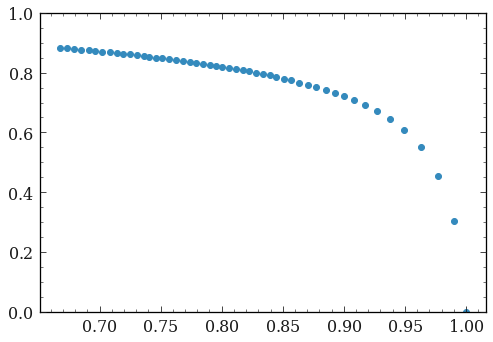

In [64]:
df = pd.DataFrame(data_dict)
plt.scatter(df.sig_eff, df.bkg_rej)

ax = plt.gca()
#ax.set_xlim(0,1)   
#ax.set_ylim(0,1)

#ax.set_xlim(0.88,1)   
ax.set_ylim(0,1)

(0.0, 1.0)

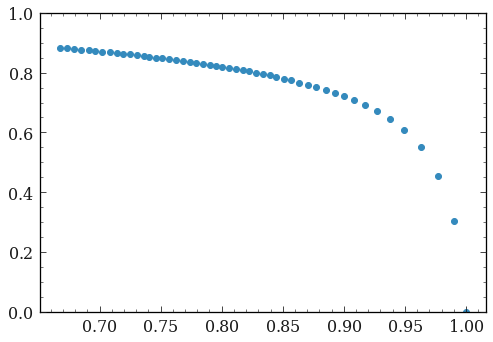

In [65]:
df = pd.DataFrame(data_dict)
plt.scatter(df.sig_eff, df.bkg_rej)

ax = plt.gca()
#ax.set_xlim(0,1)   
#ax.set_ylim(0,1)

#ax.set_xlim(0.88,1)   
ax.set_ylim(0,1)

Text(0, 0.5, 'Background retention')

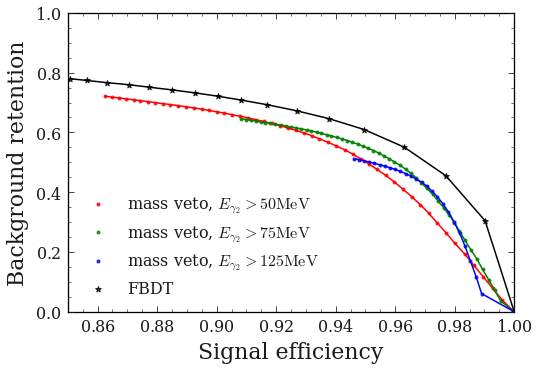

In [70]:
plt.scatter(df_50MeV.sig_eff, df_50MeV.bkg_rej , alpha=0.8, marker='.',c='red',label=r'mass veto, $E_{\gamma_2}>50\mathrm{MeV}$')
plt.scatter(df_75MeV.sig_eff, df_75MeV.bkg_rej, alpha=0.8, marker='.',c='green',label=r'mass veto, $E_{\gamma_2}>75\mathrm{MeV}$')
plt.scatter(df_125MeV.sig_eff, df_125MeV.bkg_rej, alpha=0.8, marker='.',c='blue',label=r'mass veto, $E_{\gamma_2}>125\mathrm{MeV}$')
plt.scatter(df.sig_eff, df.bkg_rej, alpha=0.8, marker='*',c='black',label=r'FBDT')

plt.plot(df_50MeV.sig_eff, df_50MeV.bkg_rej,c='red')
plt.plot(df_75MeV.sig_eff, df_75MeV.bkg_rej,c='green')
plt.plot(df_125MeV.sig_eff, df_125MeV.bkg_rej,c='blue')
plt.plot(df.sig_eff, df.bkg_rej,c='black')

plt.legend()
ax = plt.gca()
ax.set_xlim(0.85,1)   
ax.set_ylim(0,1)
ax.set_xlabel('Signal efficiency')
ax.set_ylabel('Background retention')

Text(0, 0.5, 'Background retention')

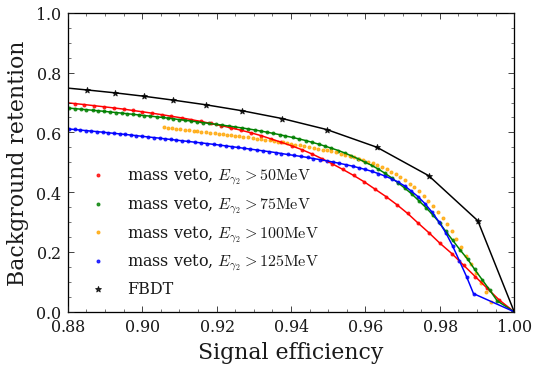

In [197]:
# plt.scatter(df_50MeV.sig_eff, df_50MeV.bkg_rej , alpha=0.8, marker='.',c='red',label=r'mass veto, $E_{\gamma_2}>50\mathrm{MeV}$')
# plt.scatter(df_75MeV.sig_eff, df_75MeV.bkg_rej, alpha=0.8, marker='.',c='green',label=r'mass veto, $E_{\gamma_2}>75\mathrm{MeV}$')
# plt.scatter(df_100MeV.sig_eff, df_100MeV.bkg_rej, alpha=0.8, marker='.',c='orange',label=r'mass veto, $E_{\gamma_2}>100\mathrm{MeV}$')

# plt.scatter(df_125MeV.sig_eff, df_125MeV.bkg_rej, alpha=0.8, marker='.',c='blue',label=r'mass veto, $E_{\gamma_2}>125\mathrm{MeV}$')
# plt.scatter(df.sig_eff, df.bkg_rej, alpha=0.8, marker='*',c='black',label=r'FBDT')

# plt.plot(df_50MeV.sig_eff, df_50MeV.bkg_rej,c='red')
# plt.plot(df_75MeV.sig_eff, df_75MeV.bkg_rej,c='green')
# plt.plot(df_125MeV.sig_eff, df_125MeV.bkg_rej,c='blue')
# plt.plot(df.sig_eff, df.bkg_rej,c='black')

# plt.legend()
# ax = plt.gca()
# ax.set_xlim(0.88,1)   
# ax.set_ylim(0,1)
# ax.set_xlabel('Signal efficiency')
# ax.set_ylabel('Background retention')

# eta

In [43]:
step = 0.005
sig_Total_row_num = pd_df_signal.shape[0]
Pi0_bkg_Total_row_num = Pi0_selected_pd_df_bkg.shape[0]
width_mass = 0.0

data_dict = dict.fromkeys(['sig_eff', 'bkg_rej'])
data_dict['sig_eff']=list()
data_dict['bkg_rej']=list()
print(data_dict)
# sig_eff_list = list()
# bkg_rej_list = list()
sig_Reduced_row_num = pd_df_signal.shape[0]
data_dict['sig_eff'].append(eff(sig_Total_row_num, sig_Reduced_row_num ))
Pi0_bkg_Reduced_row_num = Pi0_selected_pd_df_bkg.shape[0]
data_dict['bkg_rej'].append(Bkg_rej(Pi0_bkg_Total_row_num, Pi0_bkg_Reduced_row_num)) 
for i in range(1,100):     
    if width_mass < 0.100:
        width_mass     = 0 + i * step
        min_mass_bound = nominal_eta_mass - width_mass  
        max_mass_bound = nominal_eta_mass + width_mass
        #print(width_mass)
        sig_Reduced_row_num = pd_df_signal[(pd_df_signal['ROE_Eta_InvM_50MeV']<min_mass_bound) | (pd_df_signal['ROE_Eta_InvM_50MeV']>max_mass_bound)].shape[0]
        data_dict['sig_eff'].append(eff(sig_Total_row_num, sig_Reduced_row_num ))
        #sig_eff_list.append(eff(sig_Total_row_num, sig_Reduced_row_num ))
        
        Pi0_bkg_Reduced_row_num = Pi0_selected_pd_df_bkg[(Pi0_selected_pd_df_bkg['ROE_Eta_InvM_50MeV']<min_mass_bound) | (Pi0_selected_pd_df_bkg['ROE_Eta_InvM_50MeV']>max_mass_bound)].shape[0]
        data_dict['bkg_rej'].append(Bkg_rej(Pi0_bkg_Total_row_num, Pi0_bkg_Reduced_row_num))
        
        #bkg_rej_list.append(Bkg_rej(Pi0_bkg_Total_row_num, Pi0_bkg_Reduced_row_num))        
        
        


{'sig_eff': [], 'bkg_rej': []}


In [44]:
df_50MeV_eta = pd.DataFrame(data_dict)

In [45]:
step = 0.005
sig_Total_row_num = pd_df_signal.shape[0]
Pi0_bkg_Total_row_num = Pi0_selected_pd_df_bkg.shape[0]
width_mass = 0.0

data_dict = dict.fromkeys(['sig_eff', 'bkg_rej'])
data_dict['sig_eff']=list()
data_dict['bkg_rej']=list()
sig_Reduced_row_num = pd_df_signal.shape[0]
data_dict['sig_eff'].append(eff(sig_Total_row_num, sig_Reduced_row_num ))
Pi0_bkg_Reduced_row_num = Pi0_selected_pd_df_bkg.shape[0]
data_dict['bkg_rej'].append(Bkg_rej(Pi0_bkg_Total_row_num, Pi0_bkg_Reduced_row_num)) 
for i in range(1,100):
    if width_mass < 0.100:
        width_mass     = 0 + i * step
        min_mass_bound = nominal_eta_mass - width_mass  
        max_mass_bound = nominal_eta_mass + width_mass
        #print(width_mass)
        sig_Reduced_row_num = pd_df_signal[(pd_df_signal['ROE_Eta_InvM_75MeV']<min_mass_bound) | (pd_df_signal['ROE_Eta_InvM_75MeV']>max_mass_bound)].shape[0]
        data_dict['sig_eff'].append(eff(sig_Total_row_num, sig_Reduced_row_num ))
        #sig_eff_list.append(eff(sig_Total_row_num, sig_Reduced_row_num ))
        
        Pi0_bkg_Reduced_row_num = Pi0_selected_pd_df_bkg[(Pi0_selected_pd_df_bkg['ROE_Eta_InvM_75MeV']<min_mass_bound) | (Pi0_selected_pd_df_bkg['ROE_Eta_InvM_75MeV']>max_mass_bound)].shape[0]
        data_dict['bkg_rej'].append(Bkg_rej(Pi0_bkg_Total_row_num, Pi0_bkg_Reduced_row_num))
        
        #bkg_rej_list.append(Bkg_rej(Pi0_bkg_Total_row_num, Pi0_bkg_Reduced_row_num))   

In [46]:
df_75MeV_eta = pd.DataFrame(data_dict)
#Y = pd.DataFrame(bkg_rej_list)



In [47]:
step = 0.005
sig_Total_row_num = pd_df_signal.shape[0]
Pi0_bkg_Total_row_num = Pi0_selected_pd_df_bkg.shape[0]
width_mass = 0.0

data_dict = dict.fromkeys(['sig_eff', 'bkg_rej'])
data_dict['sig_eff']=list()
data_dict['bkg_rej']=list()
sig_Reduced_row_num = pd_df_signal.shape[0]
data_dict['sig_eff'].append(eff(sig_Total_row_num, sig_Reduced_row_num ))
Pi0_bkg_Reduced_row_num = Pi0_selected_pd_df_bkg.shape[0]
data_dict['bkg_rej'].append(Bkg_rej(Pi0_bkg_Total_row_num, Pi0_bkg_Reduced_row_num)) 
for i in range(1,100):
    if width_mass < 0.100:
        width_mass     = 0 + i * step
        min_mass_bound = nominal_eta_mass - width_mass  
        max_mass_bound = nominal_eta_mass + width_mass
        #print(width_mass)
        sig_Reduced_row_num = pd_df_signal[(pd_df_signal['ROE_Eta_InvM_100MeV']<min_mass_bound) | (pd_df_signal['ROE_Eta_InvM_100MeV']>max_mass_bound)].shape[0]
        data_dict['sig_eff'].append(eff(sig_Total_row_num, sig_Reduced_row_num ))
        #sig_eff_list.append(eff(sig_Total_row_num, sig_Reduced_row_num ))
        
        Pi0_bkg_Reduced_row_num = Pi0_selected_pd_df_bkg[(Pi0_selected_pd_df_bkg['ROE_Eta_InvM_100MeV']<min_mass_bound) | (Pi0_selected_pd_df_bkg['ROE_Eta_InvM_100MeV']>max_mass_bound)].shape[0]
        data_dict['bkg_rej'].append(Bkg_rej(Pi0_bkg_Total_row_num, Pi0_bkg_Reduced_row_num))
        
        #bkg_rej_list.append(Bkg_rej(Pi0_bkg_Total_row_num, Pi0_bkg_Reduced_row_num))   

In [48]:
df_100MeV_eta = pd.DataFrame(data_dict)
#Y = pd.DataFrame(bkg_rej_list)



In [49]:
step = 0.005
sig_Total_row_num = pd_df_signal.shape[0]
Pi0_bkg_Total_row_num = Pi0_selected_pd_df_bkg.shape[0]
width_mass = 0.0

data_dict = dict.fromkeys(['sig_eff', 'bkg_rej'])
data_dict['sig_eff']=list()
data_dict['bkg_rej']=list()
sig_Reduced_row_num = pd_df_signal.shape[0]
data_dict['sig_eff'].append(eff(sig_Total_row_num, sig_Reduced_row_num ))
Pi0_bkg_Reduced_row_num = Pi0_selected_pd_df_bkg.shape[0]
data_dict['bkg_rej'].append(Bkg_rej(Pi0_bkg_Total_row_num, Pi0_bkg_Reduced_row_num)) 
for i in range(1,100):
    if width_mass < 0.100:
        width_mass     = 0 + i * step
        min_mass_bound = nominal_pi0_mass - width_mass  
        max_mass_bound = nominal_pi0_mass + width_mass
        #print(width_mass)
        sig_Reduced_row_num = pd_df_signal[(pd_df_signal['ROE_Eta_InvM_125MeV']<min_mass_bound) | (pd_df_signal['ROE_Eta_InvM_125MeV']>max_mass_bound)].shape[0]
        data_dict['sig_eff'].append(eff(sig_Total_row_num, sig_Reduced_row_num ))
        #sig_eff_list.append(eff(sig_Total_row_num, sig_Reduced_row_num ))
        
        Pi0_bkg_Reduced_row_num = Pi0_selected_pd_df_bkg[(Pi0_selected_pd_df_bkg['ROE_Eta_InvM_125MeV']<min_mass_bound) | (Pi0_selected_pd_df_bkg['ROE_Eta_InvM_125MeV']>max_mass_bound)].shape[0]
        data_dict['bkg_rej'].append(Bkg_rej(Pi0_bkg_Total_row_num, Pi0_bkg_Reduced_row_num))
        
        #bkg_rej_list.append(Bkg_rej(Pi0_bkg_Total_row_num, Pi0_bkg_Reduced_row_num))   

In [50]:
df_125MeV_eta = pd.DataFrame(data_dict)

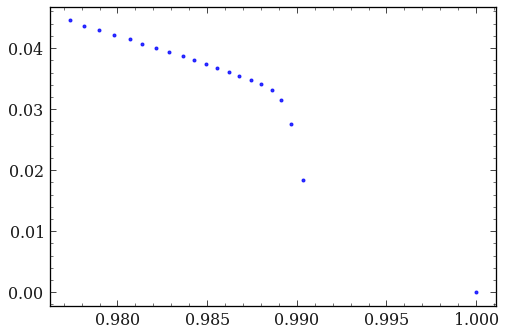

In [51]:
plt.scatter(df_125MeV_eta.sig_eff, df_125MeV_eta.bkg_rej, alpha=0.8, marker='.',c='blue',label=r'$E_{\gamma_2}>125\mathrm{MeV}$')


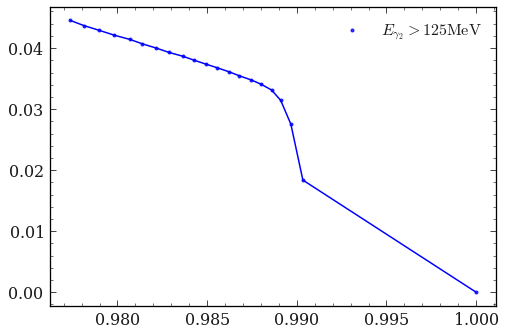

In [55]:
#plt.scatter(df_50MeV_eta.sig_eff, df_50MeV_eta.bkg_rej , alpha=0.8, marker='.',c='red',label=r'$E_{\gamma_2}>50\mathrm{MeV}$')
#plt.scatter(df_75MeV_eta.sig_eff, df_75MeV_eta.bkg_rej, alpha=0.8, marker='.',c='green',label=r'$E_{\gamma_2}>75\mathrm{MeV}$')
plt.scatter(df_125MeV_eta.sig_eff, df_125MeV_eta.bkg_rej, alpha=0.8, marker='.',c='blue',label=r'$E_{\gamma_2}>125\mathrm{MeV}$')
# plt.scatter(df.sig_eff, df.bkg_rej, alpha=0.8, marker='*',c='black',label=r'FBDT')

#plt.plot(df_50MeV_eta.sig_eff, df_50MeV_eta.bkg_rej,c='red')
#plt.plot(df_75MeV_eta.sig_eff, df_75MeV_eta.bkg_rej,c='green')
plt.plot(df_125MeV_eta.sig_eff, df_125MeV_eta.bkg_rej,c='blue')
# plt.plot(df.sig_eff, df.bkg_rej,c='black')

plt.legend()
ax = plt.gca()
# ax.set_xlim(0.88,1) 
# ax.set_xlim(0,1)   

# ax.set_ylim(0,1)

In [8]:
Total_row_num = pd_df.shape[0]
Reduced_row_num = pd_df[(pd_df['ROE_Pi0_InvM_50MeV']<0.12) | (pd_df['ROE_Pi0_InvM_50MeV']>0.145)].shape[0]



In [9]:
print(Total_row_num)
print(Reduced_row_num)

171304
158735


In [10]:
Signal_eff = Reduced_row_num/Total_row_num
print(Signal_eff)

0.9266275159949563


In [29]:

        
df = pd.DataFrame(eff_list)
df      

0.9988733479661888
0.9959603978891328
0.9927438938962313
0.9895565777798534
0.9863867743893896
0.9833570728062392
0.9799829542801102
0.9770700042030542
0.974098678372951
0.9713491804044272
0.9684654182038949
0.9655349554009247
0.962511091393079
0.9597207303974221
0.9568019427450614
0.9539240181198337
0.9511161443982628
0.9483958343062625
0.945704712090786
0.9429844019987857
0.9401648531266054
0.9373511418297296
0.9345666184093775
0.9320564610283473
0.9293595012375659
0.9266275159949563
0.9238546677252136
0.9212335964133938
0.9184549105683464
0.9158104889553075
0.9131835800681829
0.910603371783496
0.9077954980619249
0.9052561528043712
0.9026409190678559
0.9000723859337786
0.8973929388689114
0.8950345584458039
0.8923901368327651
0.8897457152197263
0.8870370802783356
0.8844451968430392
0.881853313407743


,0
0,0.998873
1,0.995960
2,0.992744
3,0.989557
4,0.986387
5,0.983357
6,0.979983
7,0.977070
8,0.974099
9,0.971349


(array([1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
        0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
        1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
        0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1.]),
 array([0.88185331, 0.88302351, 0.88419371, 0.88536391, 0.88653411,
        0.88770432, 0.88887452, 0.89004472, 0.89121492, 0.89238512,
        0.89355532, 0.89472552, 0.89589572, 0.89706592, 0.89823612,
        0.89940632, 0.90057652, 0.90174672, 0.90291692, 0.90408712,
        0.90525732, 0.90642752, 0.90759772, 0.90876792, 0.90993812,
        0.91110832, 0.91227852, 0.91344872, 0.91461892, 0.91578912,
        0.91695932, 0.91812952, 0.91929972, 0.92046992, 0.92164013,
        0.92281033, 0.92398053, 0.92515073, 0.92632093, 0.92749113,
      

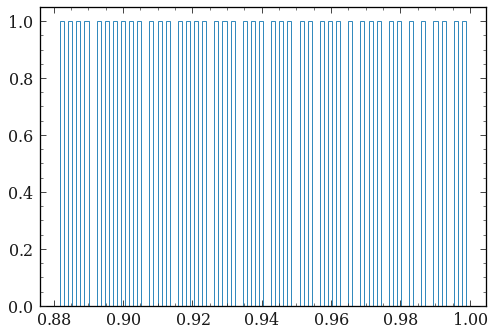

In [30]:
plt.hist(df, label=r'$E_{\gamma_{roe}}>50\mathrm{MeV}$',bins=100,histtype='step')


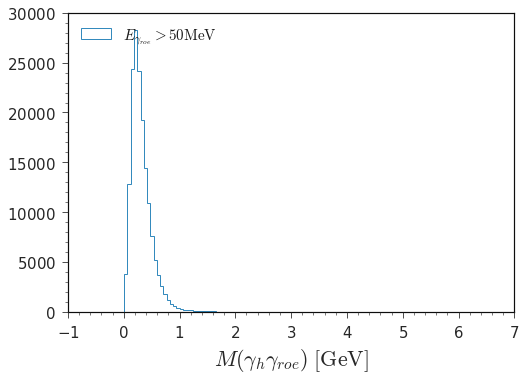

In [29]:
#plt.hist(pd_df[(pd_df['ROE_Pi0_InvM_50MeV']<0.16) & (pd_df['ROE_Pi0_InvM_50MeV']>0.1) ].ROE_Pi0_InvM_50MeV, label=r'$E_{\gamma_{roe}}>50\mathrm{MeV}$',bins=100,histtype='step')
plt.hist(pd_df[(pd_df['ROE_Pi0_InvM_50MeV']<0.12) | (pd_df['ROE_Pi0_InvM_50MeV']>0.137)].ROE_Pi0_InvM_50MeV, label=r'$E_{\gamma_{roe}}>50\mathrm{MeV}$',bins=100,histtype='step')


xlabel = r'$M(\gamma_h \gamma_{roe}) \; [\mathrm{GeV}]$'
ax = plt.gca()
#ax.set_xlim(0.10,0.16)
ax.set_xlabel(xlabel)
#plt.title(plot_title)

plt.legend(loc='upper left')

In [ ]:
plt.hist(pd_df[(pd_df['ROE_Pi0_InvM_50MeV']<0.16) & (pd_df['ROE_Pi0_InvM_50MeV']>0.1) ].ROE_Pi0_InvM_50MeV, label=r'$E_{\gamma_{roe}}>50\mathrm{MeV}$',bins=100,histtype='step')
xlabel = r'$M(\gamma_h \gamma_{roe}) \; [\mathrm{GeV}]$'
ax = plt.gca()
ax.set_xlim(0.10,0.16)
ax.set_xlabel(xlabel)
#plt.title(plot_title)

plt.legend(loc='upper left')